# <font color="blue">Milestone 3:  Diaper Manufacturing quality control using Neural Network</font>
# <font color="blue">Author: Mandar Pophali</font>
### <font color="blue">Date: 8th Dec 2019</font>

Problem Description:

For the diaper manufacturing data provided in UCI repository, plan following 

**Milestone1**
1. Read and merge data
2. Clean and prepare data 
3. Visually explore data
4. Handle class imbalance problem
5. Apply feature selection techniques to reduce dimensionality of data

**Milestone3**
6. Split prepared data from Milestone 1 into training and testing
7. Build a simple neural networks model
8. Build a DNN model
9. Build a RNN model
10. Summarize your findings with examples.  Explain what the manufacturer should focus on to optimize the diaper manufacturing process.

## Read and Merge data

In [2]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mutual_info_score

# for hyperparameter tuning
from sklearn.model_selection import GridSearchCV

%matplotlib inline


In [3]:
#load secom dataset 
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/secom/secom.data"
#Names the columns as Feature<number>

names = ["feature" + str(x) for x in range(1, 591)]
secom_var = pd.read_csv(url, sep=" ", names=names, na_values = "NaN") 

# use classification as output along with date
url_l = "https://archive.ics.uci.edu/ml/machine-learning-databases/secom/secom_labels.data"
secom_labels = pd.read_csv(url_l,sep=" ",names = ["classification","date"],parse_dates = ["date"],na_values = "NaN")

In [4]:
#combine the label and datasets
dia_merged = pd.merge(secom_var, secom_labels,left_index=True,right_index=True)

In [5]:
dia_merged.tail()

,feature1,feature2,feature3,feature4,feature5,feature6,feature7,feature8,feature9,feature10,...,feature583,feature584,feature585,feature586,feature587,feature588,feature589,feature590,classification,date
1562,2899.41,2464.36,2179.7333,3085.3781,1.4843,100.0,82.2467,0.1248,1.3424,-0.0045,...,0.4988,0.0143,0.0039,2.8669,0.0068,0.0138,0.0047,203.1720,-1,2008-10-16 15:13:00
1563,3052.31,2522.55,2198.5667,1124.6595,0.8763,100.0,98.4689,0.1205,1.4333,-0.0061,...,0.4975,0.0131,0.0036,2.6238,0.0068,0.0138,0.0047,203.1720,-1,2008-10-16 20:49:00
1564,2978.81,2379.78,2206.3000,1110.4967,0.8236,100.0,99.4122,0.1208,NaN,NaN,...,0.4987,0.0153,0.0041,3.0590,0.0197,0.0086,0.0025,43.5231,-1,2008-10-17 05:26:00
1565,2894.92,2532.01,2177.0333,1183.7287,1.5726,100.0,98.7978,0.1213,1.4622,-0.0072,...,0.5004,0.0178,0.0038,3.5662,0.0262,0.0245,0.0075,93.4941,-1,2008-10-17 06:01:00
1566,2944.92,2450.76,2195.4444,2914.1792,1.5978,100.0,85.1011,0.1235,NaN,NaN,...,0.4987,0.0181,0.0040,3.6275,0.0117,0.0162,0.0045,137.7844,-1,2008-10-17 06:07:00


In [6]:
dia_merged.shape

(1567, 592)

In [7]:
dia_merged.classification.value_counts()

-1    1463
 1     104
Name: classification, dtype: int64

**Initial summary of dataset**
1. The dataset contains 590 sensor data for manufacturing of diapers. There are total 1567 data which represents machine runs from 19th July 2008 to 17th Oct 2008 (3 months)
2. Classification feature is the dependant feature. '-1' represents successfull run while '1' represents failure
3. Output class has imbalanced data (14:1) 

In [8]:
#replace dependant feature as 1=Failure and 0=success
dia_merged.classification = dia_merged.classification.replace(-1,0)

In [9]:
dia_merged.classification.value_counts()

0    1463
1     104
Name: classification, dtype: int64

## Data Cleaning 

In [10]:
#lets convert all features to float/numberic
dia_df = dia_merged.apply(pd.to_numeric,errors='coerce')

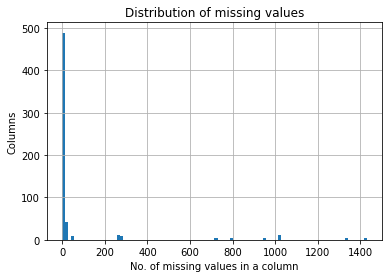

In [11]:
#check the missing values for each feature in 

data_missing= dia_df.isna().sum().sort_values(ascending=False)
data_missing.hist(bins=100)
plt.title("Distribution of missing values")
plt.xlabel("No. of missing values in a column")
plt.ylabel("Columns")
plt.show()

### lets remove all columns where there are more than 800 values missing. Its no use to fill them out with any data

In [12]:
dia_df.dropna(axis='columns',thresh=800,inplace=True)
dia_df.shape

(1567, 564)

#### From 590 features, it has come down to 564. Now lets review how many columns have same values or zero std deviation 

In [13]:
#count features having very low std deviation
dia_df.loc[:, dia_df.std() <= 0.001].nunique().count()

126

In [14]:
#drop all columns having similar values or low std deviation 
dia_new = dia_df.loc[:, dia_df.std() > 0.001]
dia_new.shape

(1567, 438)

## The total features remaining are now 438 which is 126 less than 564 in step above

In [15]:
dia_new.describe()

,feature1,feature2,feature3,feature4,feature5,feature7,feature8,feature9,feature10,feature11,...,feature583,feature584,feature585,feature586,feature587,feature588,feature589,feature590,classification,date
count,1561.000000,1560.000000,1553.000000,1553.000000,1553.000000,1553.000000,1558.000000,1565.000000,1565.000000,1565.000000,...,1566.000000,1566.000000,1566.000000,1566.000000,1566.000000,1566.000000,1566.000000,1566.000000,1567.000000,1.567000e+03
mean,3014.452896,2495.850231,2200.547318,1396.376627,4.197013,101.112908,0.121822,1.462862,-0.000841,0.000146,...,0.500096,0.015318,0.003847,3.067826,0.021458,0.016475,0.005283,99.670066,0.066369,1.217454e+18
std,73.621787,80.407705,29.513152,441.691640,56.355540,6.237214,0.008961,0.073897,0.015116,0.009302,...,0.003404,0.017180,0.003720,3.578033,0.012358,0.008808,0.002867,93.891919,0.249005,7.023985e+15
min,2743.240000,2158.750000,2060.660000,0.000000,0.681500,82.131100,0.000000,1.191000,-0.053400,-0.034900,...,0.477800,0.006000,0.001700,1.197500,-0.016900,0.003200,0.001000,0.000000,0.000000,1.199758e+18
25%,2966.260000,2452.247500,2181.044400,1081.875800,1.017700,97.920000,0.121100,1.411200,-0.010800,-0.005600,...,0.497900,0.011600,0.003100,2.306500,0.013425,0.010600,0.003300,44.368600,0.000000,1.215618e+18
50%,3011.490000,2499.405000,2201.066700,1285.214400,1.316800,101.512200,0.122400,1.461600,-0.001300,0.000400,...,0.500200,0.013800,0.003600,2.757650,0.020500,0.014800,0.004600,71.900500,0.000000,1.219497e+18
75%,3056.650000,2538.822500,2218.055500,1591.223500,1.525700,104.586700,0.123800,1.516900,0.008400,0.005900,...,0.502375,0.016500,0.004100,3.295175,0.027600,0.020300,0.006400,114.749700,0.000000,1.222082e+18
max,3356.350000,2846.440000,2315.266700,3715.041700,1114.536600,129.252200,0.128600,1.656400,0.074900,0.053000,...,0.509800,0.476600,0.104500,99.303200,0.102800,0.079900,0.028600,737.304800,1.000000,1.228935e+18


In [16]:
#check for missing values in the data
dia_new.isna().sum().sort_values(ascending=False)

feature248        715
feature520        715
feature386        715
feature113        715
feature567        273
                 ... 
feature157          0
feature222          0
classification      0
feature256          0
date                0
Length: 438, dtype: int64

In [17]:
#i am going to remove top 4 features which are having 715 missing values 
dia_new = dia_new.drop(['feature248','feature520','feature386','feature113'],axis=1)
dia_new.shape

(1567, 434)

#### replace missing values using experimental iterative imputer

In [18]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
imp = IterativeImputer(max_iter=3, random_state=0)
dia = pd.DataFrame(imp.fit_transform(dia_new),columns=dia_new.columns)

In [19]:
#check for missing values in the new dataframe to confirm
dia.isna().sum().sort_values(ascending=False)

date          0
feature172    0
feature161    0
feature162    0
feature163    0
             ..
feature392    0
feature393    0
feature394    0
feature406    0
feature1      0
Length: 434, dtype: int64

In [20]:
dia.head()

,feature1,feature2,feature3,feature4,feature5,feature7,feature8,feature9,feature10,feature11,...,feature583,feature584,feature585,feature586,feature587,feature588,feature589,feature590,classification,date
0,3030.93,2564.00,2187.7333,1411.1265,1.3602,97.6133,0.1242,1.5005,0.0162,-0.0034,...,0.5005,0.0118,0.0035,2.3630,0.023282,0.006882,0.000209,100.852593,0.0,1.216468e+18
1,3095.78,2465.14,2230.4222,1463.6606,0.8294,102.3433,0.1247,1.4966,-0.0005,-0.0148,...,0.5019,0.0223,0.0055,4.4447,0.009600,0.020100,0.006000,208.204500,0.0,1.216471e+18
2,2932.61,2559.94,2186.4111,1698.0172,1.5102,95.4878,0.1241,1.4436,0.0041,0.0013,...,0.4958,0.0157,0.0039,3.1745,0.058400,0.048400,0.014800,82.860200,1.0,1.216473e+18
3,2988.72,2479.90,2199.0333,909.7926,1.3204,104.2367,0.1217,1.4882,-0.0124,-0.0033,...,0.4990,0.0103,0.0025,2.0544,0.020200,0.014900,0.004400,73.843200,0.0,1.216479e+18
4,3032.24,2502.87,2233.3667,1326.5200,1.5334,100.3967,0.1235,1.5031,-0.0031,-0.0072,...,0.4800,0.4766,0.1045,99.3032,0.020200,0.014900,0.004400,73.843200,0.0,1.216481e+18


## In case of imbalaced data, random forests or decision tree based algorithms may peform better. Lets use random Forests classifier and get feature importance

In [21]:
#separate x and y in dataset 
y = dia['classification']
X = dia.drop(['classification','date'],axis=1)

In [22]:
#split data in train and test
from sklearn.model_selection import train_test_split


In [23]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=1000, random_state=7)
rf.fit(X, y)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=None, oob_score=False, random_state=7, verbose=0,
                       warm_start=False)

In [24]:
# displaying features and their rank

importance = rf.feature_importances_
ranked_indices = np.argsort(importance)[::-1]

print("Feature Rank:")
for i in range(15):
    print("{0:3d} column  {1:3d}  {2:6.4f}".format(i+1, ranked_indices[i], importance[ranked_indices[i]]))
print ("\n")
for i in range(len(importance)-5,len(importance)):
    print("{0:3d} column  {1:3d}  {2:6.4f}".format(i+1, ranked_indices[i], importance[ranked_indices[i]]))

navg = 0
for i in range(len(importance)):    
    if importance[ranked_indices[i]] > np.average(rf.feature_importances_):
        navg = navg+1
print('The number of features better than average is: {}'.format(navg))

Feature Rank:
  1 column   59  0.0119
  2 column   54  0.0110
  3 column   60  0.0080
  4 column  408  0.0073
  5 column  314  0.0069
  6 column   89  0.0068
  7 column   38  0.0067
  8 column  205  0.0064
  9 column  132  0.0064
 10 column   36  0.0058
 11 column  355  0.0058
 12 column  269  0.0057
 13 column  329  0.0056
 14 column   23  0.0053
 15 column   65  0.0052


428 column  177  0.0000
429 column  356  0.0000
430 column  174  0.0000
431 column  265  0.0000
432 column  268  0.0000
The number of features better than average is: 154


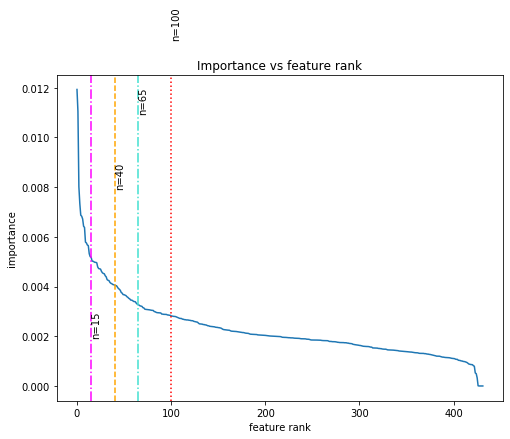

In [25]:
# plot of importance vs the number of features

plt.figure(figsize=(8,6))
plt.plot(range(len(importance)), importance[ranked_indices[:]])
plt.axvline(15, color='magenta', linestyle='dashdot', label='n=15')
plt.axvline(40, color='orange', linestyle='dashed', label='n=40')
plt.axvline(65, color='turquoise', linestyle='dashdot', label='n=65')
plt.axvline(100, color='red', linestyle='dotted', label='n=100')
plt.text(15, 0.002, 'n=15', rotation='vertical')
plt.text(40, 0.008, 'n=40', rotation='vertical')
plt.text(65, 0.011, 'n=65', rotation='vertical')
plt.text(100, 0.014, 'n=100', rotation='vertical')
plt.title('Importance vs feature rank')
plt.xlabel('feature rank')
plt.ylabel('importance')
plt.show()

### From this plot, we see points of inflection around the 15, 40, 65 and 100 mark. The 50 percentile mark is at 148 so these are reduced feature sets, much smaller than the 434 features we have after cleaning the data

In [26]:
#select first 148 features for next analysis
dia_importances = pd.Series(rf.feature_importances_, index=X.columns)
selected = list(dia_importances.nlargest(148).index)
selected

['feature65',
 'feature60',
 'feature66',
 'feature563',
 'feature427',
 'feature104',
 'feature41',
 'feature268',
 'feature154',
 'feature39',
 'feature478',
 'feature349',
 'feature442',
 'feature26',
 'feature72',
 'feature426',
 'feature342',
 'feature17',
 'feature27',
 'feature211',
 'feature206',
 'feature78',
 'feature302',
 'feature133',
 'feature22',
 'feature100',
 'feature3',
 'feature153',
 'feature288',
 'feature540',
 'feature52',
 'feature64',
 'feature575',
 'feature353',
 'feature167',
 'feature332',
 'feature212',
 'feature552',
 'feature511',
 'feature430',
 'feature438',
 'feature103',
 'feature122',
 'feature351',
 'feature1',
 'feature436',
 'feature289',
 'feature82',
 'feature568',
 'feature551',
 'feature495',
 'feature562',
 'feature555',
 'feature124',
 'feature476',
 'feature63',
 'feature558',
 'feature424',
 'feature213',
 'feature300',
 'feature157',
 'feature583',
 'feature334',
 'feature360',
 'feature89',
 'feature171',
 'feature461',
 'feature165',


In [27]:
#create final DataFrame with 148 features
dia_final = dia[selected].join(y)

In [28]:
dia_final.shape

(1567, 149)

In [29]:
X = dia_final.iloc[:,:148]
y = dia_final.iloc[:,148]

In [30]:
#!pip install -U imbalanced-learn --user

In [31]:
#as previously noted, the dataset is highly imbalanced (13:1). I am proposing to use SMOTE to increase percentage of 
#minority class in dataset
from imblearn.over_sampling import SMOTE

#create SMOTE object
sm = SMOTE(sampling_strategy=1.0,k_neighbors=3,random_state=1)
X_sm, y_sm = sm.fit_sample(X,y)

In [32]:
#both classes are now equally populated 
np.unique(y_sm,return_counts=True)

(array([0., 1.]), array([1463, 1463], dtype=int64))

In [33]:
# splitting them into train test and split

from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X_sm, y_sm, test_size = 0.2, random_state = 1)

# gettiing the shapes
print("shape of x_train: ", x_train.shape)
print("shape of x_test: ", x_test.shape)
print("shape of y_train: ", y_train.shape)
print("shape of y_test: ", y_test.shape)

shape of x_train:  (2340, 148)
shape of x_test:  (586, 148)
shape of y_train:  (2340,)
shape of y_test:  (586,)


In [34]:
#lets scale the dataset
from sklearn.preprocessing import StandardScaler

#creating a standard scaler
scaler = StandardScaler()

#scale the independant datasets
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

In [110]:
Y_tf = y_train.values

## Simple Neural Network Model

In [41]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report 

In [75]:
mlp = MLPClassifier(activation = 'relu',solver= 'adam',alpha= 0.001, learning_rate='constant',momentum= 0.9,
                    hidden_layer_sizes=(100,100,100,100,100,100,100,100,100), max_iter=500,early_stopping=True)

mlp.fit(x_train, y_train.values.ravel())

MLPClassifier(activation='relu', alpha=0.001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=True, epsilon=1e-08,
              hidden_layer_sizes=(100, 100, 100, 100, 100, 100, 100, 100, 100),
              learning_rate='constant', learning_rate_init=0.001, max_fun=15000,
              max_iter=500, momentum=0.9, n_iter_no_change=10,
              nesterovs_momentum=True, power_t=0.5, random_state=None,
              shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
              verbose=False, warm_start=False)

In [76]:
predictions = mlp.predict(x_test)

In [77]:
print(confusion_matrix(y_test,predictions))
print(classification_report(y_test,predictions))

[[293   7]
 [  2 284]]
              precision    recall  f1-score   support

         0.0       0.99      0.98      0.98       300
         1.0       0.98      0.99      0.98       286

    accuracy                           0.98       586
   macro avg       0.98      0.98      0.98       586
weighted avg       0.98      0.98      0.98       586



## Lets apply random search to optimize hyperparameters

In [78]:
from sklearn.model_selection import RandomizedSearchCV
import itertools 

parameters = {'solver': ['sgd','adam'], 'activation': ['tanh','relu'],'learning_rate': ['adaptive','constant'],'hidden_layer_sizes':[x for x in itertools.product((10,50,100),repeat=9)]}
clf_grid = RandomizedSearchCV(MLPClassifier(max_iter=500,early_stopping=True), parameters, cv=12, scoring='f1',n_jobs=-1)

In [80]:
clf_grid.fit(x_train,y_train)

RandomizedSearchCV(cv=12, error_score=nan,
                   estimator=MLPClassifier(activation='relu', alpha=0.0001,
                                           batch_size='auto', beta_1=0.9,
                                           beta_2=0.999, early_stopping=True,
                                           epsilon=1e-08,
                                           hidden_layer_sizes=(100,),
                                           learning_rate='constant',
                                           learning_rate_init=0.001,
                                           max_fun=15000, max_iter=500,
                                           momentum=0.9, n_iter_no_change=10,
                                           nesterovs_momentum=True, power_t=0.5,
                                           random...
                                                               (10, 10, 10, 10,
                                                                10, 10, 100,
                      

In [81]:
#best parameter values
clf_grid.best_estimator_

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=True, epsilon=1e-08,
              hidden_layer_sizes=(100, 50, 50, 50, 10, 50, 50, 100, 10),
              learning_rate='adaptive', learning_rate_init=0.001, max_fun=15000,
              max_iter=500, momentum=0.9, n_iter_no_change=10,
              nesterovs_momentum=True, power_t=0.5, random_state=None,
              shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
              verbose=False, warm_start=False)

In [82]:
print('-'*53)
print('Classification report with gridCV optimzation')
print('-'*53)
print(classification_report(y_test,clf_grid.predict(x_test)))

-----------------------------------------------------
Classification report with gridCV optimzation
-----------------------------------------------------
              precision    recall  f1-score   support

         0.0       1.00      0.97      0.98       300
         1.0       0.97      1.00      0.98       286

    accuracy                           0.98       586
   macro avg       0.98      0.98      0.98       586
weighted avg       0.98      0.98      0.98       586



In [83]:
# let's plot the confusion matrix
cm1 = pd.DataFrame(index = clf_grid.best_estimator_.classes_, 
                   columns = clf_grid.best_estimator_.classes_,
                   data = confusion_matrix(y_test,clf_grid.predict(x_test)))
cm1.columns.name = 'Actual'
cm1.index.name = 'Predicted'
cm1

Actual,0.0,1.0
Predicted,,
0.0,292,8
1.0,1,285


## Deep neural network using tensorflow 2.x

In [85]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [86]:
# Similar to setting random_state in sklearn, but does so more broadly
tf.compat.v1.random.set_random_seed(7299)

In [88]:
#instantiate sequencial object
tfclf = tf.keras.Sequential()

In [198]:
#lets add 9 hidden layers of 20 units each
tfclf.add(layers.Dense(148, activation='relu',input_dim=148))

In [199]:
# also have to add the output layer
tfclf.add(layers.Dense(1, activation='sigmoid'))

In [200]:
# pick an optimizer
optimizer = keras.optimizers.Adam(learning_rate = 0.01, beta_1 = 0.1, beta_2 = 0.1)

In [201]:
# compile the model
# the metrics parameter is just for reporting
tfclf.compile(optimizer = optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [202]:
x_test = np.array(x_test) 
#y_test = np.array(y_test)

In [203]:
# Fit and predict
tfclf.fit(x_train, Y_tf, epochs=10, batch_size=100, verbose=1)
Ytfclf = tfclf.predict(x_train).ravel()

Train on 2340 samples
Epoch 1/10
2340/2340 [==============================] - 4s 2ms/sample - loss: 0.6970 - accuracy: 0.4868
Epoch 2/10
2340/2340 [==============================] - 1s 245us/sample - loss: 0.6948 - accuracy: 0.4970
Epoch 3/10
2340/2340 [==============================] - 0s 161us/sample - loss: 0.6957 - accuracy: 0.4902
Epoch 4/10
2340/2340 [==============================] - 1s 269us/sample - loss: 0.6939 - accuracy: 0.5038
Epoch 5/10
2340/2340 [==============================] - 0s 153us/sample - loss: 0.6940 - accuracy: 0.5004
Epoch 6/10
2340/2340 [==============================] - 0s 161us/sample - loss: 0.6936 - accuracy: 0.4987
Epoch 7/10
2340/2340 [==============================] - 0s 153us/sample - loss: 0.6940 - accuracy: 0.4902
Epoch 8/10
2340/2340 [==============================] - 0s 161us/sample - loss: 0.6937 - accuracy: 0.4962
Epoch 9/10
2340/2340 [==============================] - 0s 165us/sample - loss: 0.6936 - accuracy: 0.4996
Epoch 10/10
2340/2340 [===

# Decision tree classifier

In [0]:
from sklearn.tree import DecisionTreeClassifier
# for model evaluation


In [0]:
dtc = DecisionTreeClassifier(max_depth=40,min_samples_split=4,min_samples_leaf=1,random_state=987)
dtc.fit(x_train,y_train)

# predict (on both train and test sets)
y_train_dtc = dtc.predict(x_train)
y_test_dtc = dtc.predict(x_test)

In [0]:
print('-'*55)
print('Training scores')
print('-'*55)
print(classification_report(y_train, y_train_dtc))
print()
print('-'*55)
print('Test scores decision tree')
print('-'*55)
print(classification_report(y_test, y_test_dtc))
print('-'*55)

In [0]:
    # let's plto the confusion matrix
    cm1 = pd.DataFrame(index = dtc.classes_, 
                       columns = dtc.classes_,
                       data = confusion_matrix(y_test, y_test_dtc))
    cm1.columns.name = 'Actual'
    cm1.index.name = 'Predicted'
    cm1

# Lets check if we can we do better using gridsearch

In [0]:
param_grid = [
    {'min_samples_split': [2,3,4,5], 'max_depth': [20,40,60,80],'min_samples_leaf':[1,2,3,4]}
]
gsCV = GridSearchCV(DecisionTreeClassifier(random_state=987),param_grid=param_grid, cv=12,scoring='recall',n_jobs=-1)
gsCV.fit(x_train,y_train)

In [0]:
# this is the best decision tree model.  It's of class DecisionTreeClassifier
gsCV.best_estimator_

In [0]:
print('-'*55)
print('Test scores from Grid search Decision tree')
print('-'*55)
print(classification_report(y_test, gsCV.predict(x_test)))
print('-'*55)
print('Test scores decision tree')
print('-'*55)
print(classification_report(y_test, y_test_dtc))
print('-'*55)

### There is hardly any diffrence between the two.

# Random Forest Classifier

In [0]:
min_samples_split = 64
max_leaf_nodes = 64
rfc = RandomForestClassifier(n_estimators=1000,
                             max_leaf_nodes=max_leaf_nodes, 
                             min_samples_split=min_samples_split)
rfc.fit(x_train, y_train)

# predict (on both train and test sets)
y_train_rfc = rfc.predict(x_train)
y_test_rfc = rfc.predict(x_test)

In [0]:
print('-'*53)
print('Random Forest with non-optimal gridCV parameters')
print('-'*53)
print(classification_report(y_test, y_test_rfc))
print('-'*53)
print('Non- Optimized Decision Tree')
print('-'*53)
print(classification_report(y_test,y_test_dtc))

### There is definetely improvement as compared to decision tree. 

In [0]:
# let's plot the confusion matrix
cm2 = pd.DataFrame(index = rfc.classes_, 
                   columns = rfc.classes_,
                   data = confusion_matrix(y_test, y_test_rfc))
cm2.columns.name = 'Actual'
cm2.index.name = 'Predicted'
cm2

# Lets check if we can we do better using gridsearch

In [1]:
param_grid = [
    {'max_leaf_nodes':[20,40,80,100],'n_estimators':[100,500,1000,10000]}
]
rfgsCV = GridSearchCV(RandomForestClassifier(min_samples_split=64),param_grid=param_grid, cv=24,scoring='recall',n_jobs=-1)
rfgsCV.fit(x_train,y_train.values.reshape(-1,))

NameError: name 'GridSearchCV' is not defined

In [0]:
# this is the best decision tree model.  It's of class RandomForestClassifier
rfgsCV.best_estimator_

In [0]:
print('-'*53)
print('Random Forest with non-optimal gridCV parameters')
print('-'*53)
print(classification_report(y_test, y_test_rfc))
print('-'*53)
print('Random Forest with optimal gridCV parameters')
print('-'*53)
print(classification_report(y_test,rfgsCV.predict(x_test)))

In [0]:
# let's plot the confusion matrix
cm3 = pd.DataFrame(index = rfgsCV.classes_, 
                   columns = rfgsCV.classes_,
                   data = confusion_matrix(y_test, rfgsCV.predict(x_test)))
cm3.columns.name = 'Actual'
cm3.index.name = 'Predicted'
cm3

# SVM

In [0]:
#I am proposing to use svmSMOTE instead of earlier one. 
from imblearn.over_sampling import SVMSMOTE

#create SMOTE object
smv = SVMSMOTE(sampling_strategy=1.0,k_neighbors=3,random_state=1)
X_sv, y_sv = smv.fit_sample(X,y)

In [0]:
#check how classes are populated 
np.unique(y_sv,return_counts=True)

In [0]:
# splitting them into train test and split

from sklearn.model_selection import train_test_split

x_train1, x_test1, y_train1, y_test1 = train_test_split(X_sv, y_sv, test_size = 0.3, random_state = 0)

# gettiing the shapes
print("shape of x_train1: ", x_train1.shape)
print("shape of x_test1: ", x_test1.shape)
print("shape of y_train1: ", y_train1.shape)
print("shape of y_test1: ", y_test1.shape)

In [0]:
#lets scale the dataset
from sklearn.preprocessing import StandardScaler

#creating a standard scaler
scaler = StandardScaler()

#scale the independant datasets
x_train1 = scaler.fit_transform(x_train1)
x_test1 = scaler.transform(x_test1)

In [0]:
from sklearn.svm import SVC

In [0]:
clfSVC = SVC(kernel='poly',degree=3,C=10,random_state=8,gamma='auto')
clfSVC.fit(x_train1, y_train1)

# predict (on both train and test sets)
y_train_svc = clfSVC.predict(x_train1)
y_test_svc = clfSVC.predict(x_test1)

In [0]:
print('-'*53)
print('Random Forest with non-optimal gridCV parameters')
print('-'*53)
print(classification_report(y_test, y_test_rfc))
print('-'*53)
print('Non- Optimized SVM ')
print('-'*53)
print(classification_report(y_test1,y_test_svc))

In [0]:
# let's plot the confusion matrix
cm3 = pd.DataFrame(index = clfSVC.classes_, 
                   columns = clfSVC.classes_,
                   data = confusion_matrix(y_test1, y_test_svc))
cm3.columns.name = 'Actual'
cm3.index.name = 'Predicted'
cm3

# Conclusion

Support Vector Machine with SVMSMOTE is clearly giving best results for recall/precision for faulty sensors predictions. Even after applying grid seaarch, the randomForest and decision trees are not able to provide same level of accuracy